In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import ViTModel
from PIL import Image
import os

In [4]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "F:/Class/FYP/newdataset/train"
val_dir = "F:/Class/FYP/newdataset/validation"
batch_size = 32
num_epochs = 10

In [5]:
# Dataset with dual transforms
class HybridImageDataset(Dataset):
    def __init__(self, root_dir):
        
        self.efficientnet_transform = transforms.Compose([
            transforms.Resize((300, 300)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.vit_transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        return (
            self.efficientnet_transform(image), 
            self.vit_transform(image), 
            torch.tensor(self.labels[idx])
        )

In [6]:
# Load pre-trained EfficientNet model
def load_efficientnet(model_path, num_classes):
    model = models.efficientnet_b3(weights="IMAGENET1K_V1")
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    # Load saved weights
    checkpoint = torch.load(model_path, map_location=device)
    
    # Get the state dict from checkpoint
    state_dict = checkpoint['model_state_dict']
    
    # Create a new state dict that matches the model's expected keys
    model_state_dict = model.state_dict()
    new_state_dict = {}
    
    for key in model_state_dict.keys():
        if key in state_dict:
            new_state_dict[key] = state_dict[key]
        else:
            # Check if the key exists with a different prefix in the checkpoint
            prefixed_key = f'efficientnet.{key}'
            if prefixed_key in state_dict:
                new_state_dict[key] = state_dict[prefixed_key]
            else:
                # Raise an error if no matching key is found in the checkpoint
                raise KeyError(f"No matching weight found for {key} in checkpoint!")
    
    # Load the adapted state dict
    model.load_state_dict(new_state_dict)
    
    # Remove classification head to get features
    efficientnet_features = nn.Sequential(*list(model.children())[:-1])
    return efficientnet_features, 1536

In [7]:
def load_vit(model_path, num_classes):
    # Load the pre-trained ViT model from Hugging Face
    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-384')
    
    # Define the classifier head
    vit_classifier = nn.Linear(vit_model.config.hidden_size, num_classes)
    
    # Load the checkpoint file
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load the model state dict from the checkpoint (if exists)
    checkpoint_state_dict = checkpoint.get('model_state', {})
    vit_model.load_state_dict({key: checkpoint_state_dict.get(key, vit_model.state_dict()[key]) for key in vit_model.state_dict().keys()})
    
    # Load classifier weights from checkpoint (if exists)
    vit_classifier.weight.data = checkpoint_state_dict.get('head.weight', nn.init.normal_(vit_classifier.weight, std=0.02))
    vit_classifier.bias.data = checkpoint_state_dict.get('head.bias', nn.init.zeros_(vit_classifier.bias))
    
    return vit_model, vit_classifier

In [8]:
class FeatureFusionHybrid(nn.Module):
    def __init__(self, efficientnet_features, vit_model, vit_classifier, efficientnet_dim, vit_dim, num_classes):
        super().__init__()
        self.efficientnet_features = efficientnet_features
        self.vit = vit_model
        self.head = vit_classifier
        
        # Freeze layers in feature extractors
        for param in self.efficientnet_features.parameters():
            param.requires_grad = False
        for param in self.vit.parameters():
            param.requires_grad = False
        
        # Fusion layers
        combined_dim = efficientnet_dim + vit_dim
        self.fusion = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, efficientnet_x, vit_x):
        # Extract features from EfficientNet
        efficientnet_features = self.efficientnet_features(efficientnet_x)
        efficientnet_features = torch.flatten(efficientnet_features, 1)
        
        # Extract features from ViT (CLS token)
        vit_outputs = self.vit(pixel_values=vit_x)
        vit_features = vit_outputs.last_hidden_state[:, 0, :]
        
        # Concatenate the features from both models
        combined_features = torch.cat([efficientnet_features, vit_features], dim=1)
        
        # Pass the combined features through the fusion layers
        return self.fusion(combined_features)

In [9]:
# Main execution
if __name__ == "__main__":
    # Load datasets
    train_dataset = HybridImageDataset(train_dir)
    val_dataset = HybridImageDataset(val_dir)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    num_classes = len(train_dataset.classes)
    
    # Load pre-trained models
    efficientnet_path = "efficientnet_b3_finetuned_final.pth"
    vit_path = "vit_model_384_finetuned.pth"
    
    # Load the pre-trained ViT model and classifier weights
    vit_model, vit_classifier = load_vit(vit_path, num_classes=len(train_dataset.classes))
    
    # Load pre-trained EfficientNet features
    efficientnet_features, efficientnet_dim = load_efficientnet(efficientnet_path, num_classes=len(train_dataset.classes))
    
    # Create the hybrid model
    model = FeatureFusionHybrid(
        efficientnet_features,
        vit_model,
        vit_classifier,
        efficientnet_dim,
        768,  # ViT's feature dim
        num_classes=len(train_dataset.classes)
    ).to(device)
    
    # Smaller learning rate since just for training the fusion layer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    # Early stopping setup
    patience = 2
    epochs_no_improve = 0
    best_accuracy = 0
    best_model_wts = None
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for efficientnet_images, vit_images, labels in train_loader:
            efficientnet_images = efficientnet_images.to(device)
            vit_images = vit_images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(efficientnet_images, vit_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0
        
        with torch.no_grad():
            for efficientnet_images, vit_images, labels in val_loader:
                efficientnet_images = efficientnet_images.to(device)
                vit_images = vit_images.to(device)
                labels = labels.to(device)
                
                outputs = model(efficientnet_images, vit_images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)
        
        scheduler.step(val_accuracy)
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Early Stopping Logic
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            print(f"Validation accuracy improved: {val_accuracy:.2f}%")
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'class_names': train_dataset.classes
            }, "pill_detection_fusion_hybrid.pth")
            print(f"Best model saved with accuracy: {val_accuracy:.2f}%")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation accuracy for {epochs_no_improve} epochs.")
        
        # If no improvement for patience epochs, stop training
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"Training completed. Best validation accuracy: {best_accuracy:.2f}%")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\AppData\Local\Temp\ipykernel_9812\1819988099.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa

Epoch 1: Train Loss: 0.2223, Train Acc: 96.45% | Val Loss: 0.0391, Val Acc: 98.75%
Validation accuracy improved: 98.75%
Best model saved with accuracy: 98.75%
Epoch 2: Train Loss: 0.0495, Train Acc: 98.67% | Val Loss: 0.0333, Val Acc: 98.97%
Validation accuracy improved: 98.97%
Best model saved with accuracy: 98.97%
Epoch 3: Train Loss: 0.0358, Train Acc: 98.97% | Val Loss: 0.0310, Val Acc: 99.01%
Validation accuracy improved: 99.01%
Best model saved with accuracy: 99.01%
Epoch 4: Train Loss: 0.0357, Train Acc: 98.94% | Val Loss: 0.0316, Val Acc: 99.08%
Validation accuracy improved: 99.08%
Best model saved with accuracy: 99.08%
Epoch 5: Train Loss: 0.0303, Train Acc: 99.08% | Val Loss: 0.0356, Val Acc: 99.19%
Validation accuracy improved: 99.19%
Best model saved with accuracy: 99.19%
Epoch 6: Train Loss: 0.0268, Train Acc: 99.18% | Val Loss: 0.0316, Val Acc: 99.01%
No improvement in validation accuracy for 1 epochs.
Epoch 7: Train Loss: 0.0310, Train Acc: 99.05% | Val Loss: 0.0356, Val


Classification Report:
              precision    recall  f1-score   support

     Ascozin     0.9924    0.9825    0.9874       400
      Bioflu     0.9876    0.9925    0.9900       400
    Biogesic     0.9975    0.9950    0.9962       400
    Bonamine     0.9876    0.9925    0.9900       400
    Buscopan     1.0000    0.9875    0.9937       400
     DayZinc     0.9851    0.9925    0.9888       400
    Decolgen     0.9925    0.9975    0.9950       400
      Flanax     0.9950    0.9925    0.9937       400
     Imodium     0.9875    0.9875    0.9875       400
    Lactezin     0.9900    0.9925    0.9913       400
     Lagundi     0.9827    0.9950    0.9888       400
       Midol     0.9875    0.9900    0.9888       400
      Myra_E     0.9975    0.9975    0.9975       400
  Neurogen_E     0.9975    0.9900    0.9937       400
  Omeprazole     0.9827    0.9925    0.9876       400
     Rinityn     0.9900    0.9900    0.9900       400
     Rogin_E     0.9949    0.9850    0.9899       400
   

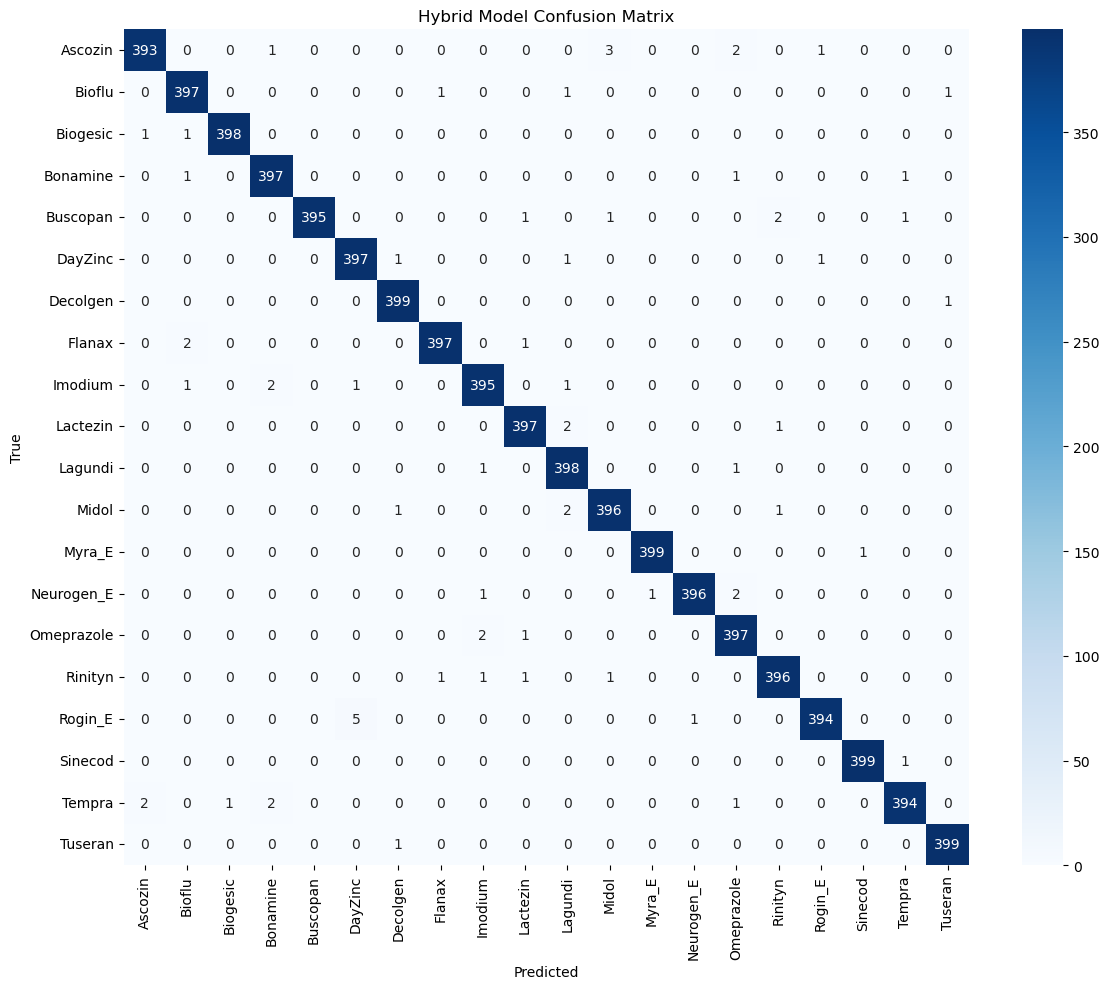


Overall Validation Accuracy: 99.16%

Per-Class Accuracy:
Ascozin: 98.25%
Bioflu: 99.25%
Biogesic: 99.50%
Bonamine: 99.25%
Buscopan: 98.75%
DayZinc: 99.25%
Decolgen: 99.75%
Flanax: 99.25%
Imodium: 98.75%
Lactezin: 99.25%
Lagundi: 99.50%
Midol: 99.00%
Myra_E: 99.75%
Neurogen_E: 99.00%
Omeprazole: 99.25%
Rinityn: 99.00%
Rogin_E: 98.50%
Sinecod: 99.75%
Tempra: 98.50%
Tuseran: 99.75%

Class-wise Precision/Recall:
Ascozin: Precision=0.992, Recall=0.983
Bioflu: Precision=0.988, Recall=0.993
Biogesic: Precision=0.997, Recall=0.995
Bonamine: Precision=0.988, Recall=0.993
Buscopan: Precision=1.000, Recall=0.988
DayZinc: Precision=0.985, Recall=0.993
Decolgen: Precision=0.993, Recall=0.998
Flanax: Precision=0.995, Recall=0.993
Imodium: Precision=0.988, Recall=0.988
Lactezin: Precision=0.990, Recall=0.993
Lagundi: Precision=0.983, Recall=0.995
Midol: Precision=0.988, Recall=0.990
Myra_E: Precision=0.998, Recall=0.998
Neurogen_E: Precision=0.997, Recall=0.990
Omeprazole: Precision=0.983, Recall=0.

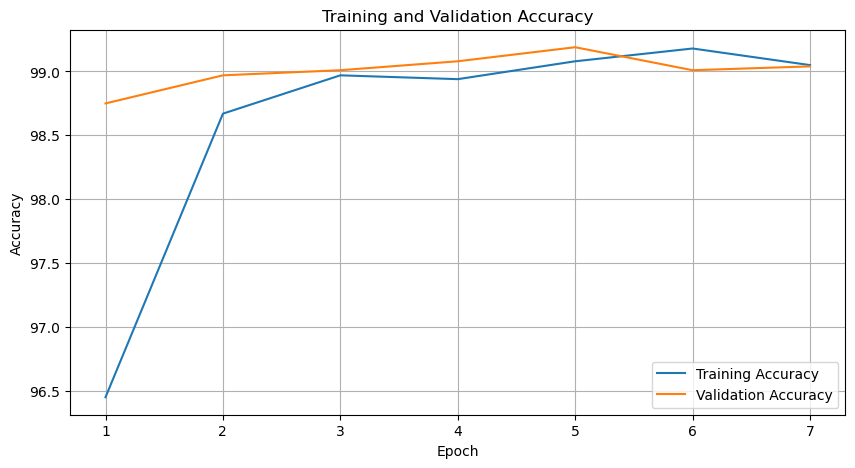

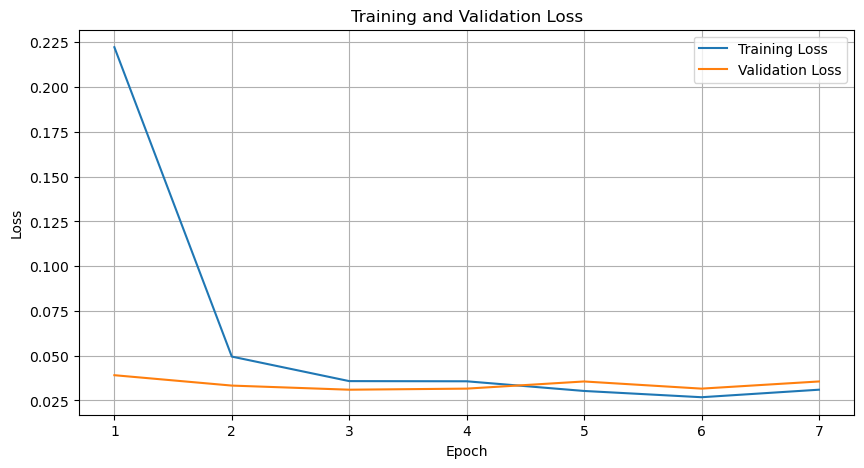

In [12]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Results from your training (manually added for clarity)
train_accuracies = [96.45, 98.67, 98.97, 98.94, 99.08, 99.18, 99.05]  # Accuracy after each epoch
val_accuracies = [98.75, 98.97, 99.01, 99.08, 99.19, 99.01, 99.04]  # Validation accuracy after each epoch
train_losses = [0.2223, 0.0495, 0.0358, 0.0357, 0.0303, 0.0268, 0.0310]  # Training loss for each epoch
val_losses = [0.0391, 0.0333, 0.0310, 0.0316, 0.0356, 0.0316, 0.0356]  # Validation loss for each epoch

# 1. Prepare the validation data for metrics calculation
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode

# Running evaluation on the validation dataset
with torch.no_grad():
    for efficientnet_images, vit_images, labels in val_loader:
        efficientnet_images = efficientnet_images.to(device)
        vit_images = vit_images.to(device)
        labels = labels.to(device)

        outputs = model(efficientnet_images, vit_images)
        _, preds = torch.max(outputs, 1)
        
        # Append predictions and ground truth labels for metric calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes, digits=4))

# 3. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Hybrid Model Confusion Matrix')
plt.tight_layout()
plt.savefig('hybrid_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Calculate Overall Accuracy
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\nOverall Validation Accuracy: {accuracy*100:.2f}%")

# Per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {class_acc[i]*100:.2f}%")

# 5. Precision-Recall for each class
print("\nClass-wise Precision/Recall:")
for i, class_name in enumerate(train_dataset.classes):
    precision = cm[i,i] / cm[:,i].sum()
    recall = cm[i,i] / cm[i,:].sum()
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}")

# 6. Plotting Training & Validation Loss and Accuracy
# Plotting Accuracy Graph
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting Loss Graph
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()